# RLDronePilot - Fully Autonomous Line-Follower Drone
This project was realized by the [REDS institute](https://reds.heig-vd.ch/) @ [HEIG-VD](https://heig-vd.ch/).

Authors: Guillaume Chacun, Mehdi Akeddar, Thomas Rieder, Bruno Da Rocha Carvalho and Marina Zapater<br>
REDS. School of Engineering and Management Vaud, HES-SO University of Applied sciences and Arts Western Switzerland<br>
Email: {guillaume.chacun, mehdi.akeddar, thomas.rieder, bruno.darochacarvalho, marina.zapater}@heig-vd.ch<br>

## Goal
This Jupyter notebook is used to train a DDPG (reinforcement learning) model to control a drone, specifically to guide it to follow a predefined line on the ground. A separate deep learning model is used to identify and track the line from images captured by the on-board camera. The pilot module processes real-world normalised coordinates of points A and B (see image below) and outputs forward, lateral and angular velocities for the drone.

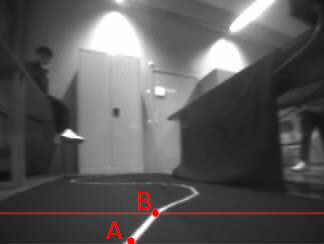

## Content of this repository
- This Notebook is used to train the reinforcement learning model.
- *ddpg_torch.py* : DDPG related classes (OUActionNoise, ReplayBuffer, CriticNetwork, ActorNetwork, Agent).
- *Drone.py* : Class to simulate the behavior of the drone.
- *Line.py* : Class to generate a random line for the drone to follow.
- *Environment.py* : Class to handle the simulation (episodes). Contains an instance of Drone and Line.

## Setup
Install dependencies:

```bash
poetry install
```

Activate the virtual environment of Poetry:
```bash
poetry shell
```

Start your Jupyter Lab server:
```bash
jupyter lab
```

## Disclaimer
Most of the DDPG code is from [@philtabor's GitHub](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/DDPG/pytorch/lunar-lander/ddpg_torch.py) (last visited on March 5th, 2024).

# Imports

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from tqdm.notebook import tqdm

In [2]:
import multiprocessing as mp

mp.set_start_method('spawn')

In [3]:
%matplotlib inline
# does not work with %matplotlib widgets

In [4]:
%load_ext autoreload
%autoreload 2
from Agents import ExplorationAgent, LearningAgent
from Drone import Drone
from Environment import Environment
from SharedReplayBuffer import SharedReplayBuffer

# Parameters

In [5]:
log = True
enable_plots = True

In [6]:
# True if existing LearnerAgent weights should be loaded
load_weights = False

In [7]:
# number of ExplorationAgent to run in parallel
n_process = 30

In [8]:
seed = 23
np.random.seed(seed)

In [9]:
# DPPG parameters
actor_lr  = 1e-5
critic_lr = 1e-4
ddpg_tau = 1e-3
batch_size = 512
layer1_size = 300
layer2_size = 150
noise_sigma = 0.1 # scale of the noise
noise_theta = 0.2 # rate at which the noise reverts to the mean
noise_dt = 5e-3   # time step size for the Ornstein-Uhlenbeck process; smaller -> smoother noise
memory_size = 0   # size of 0 disables the agent's memory

In [10]:
# Environment parameters
max_allowed_dist = 1.5 # from the drone to the nearest point on the line (meters)
# Reward weights
alpha = 2    # distance
beta = 0.5   # speed
gamma = 1.   # p1 centered
delta = .5   # angle
terminated_reward = -1 * sum([alpha, beta, gamma, delta])

In [11]:
# Drone parameters
allow_x_movement = True
z_min_speed = .05        # meters / second
z_max_speed = .30        # meters / second
x_max_speed = .15        # meters / second
max_angular_speed = 45.  # degrees / seconds
max_drift = 0.           # meters

In [12]:
state_dims = 3
n_actions = 3 if allow_x_movement else 2
input_dims = [state_dims + state_dims*memory_size]

# Setup

In [13]:
neptune_params = {
    'Model/load_weights': load_weights,
    'Model/state_dims': state_dims,
    'Model/n_actions': n_actions,
    
    'Model/actor_lr': actor_lr,
    'Model/critic_lr': critic_lr,
    'Model/tau': ddpg_tau,
    'Model/batch_size': batch_size,
    'Model/layer1_size': layer1_size,
    'Model/layer2_size': layer2_size,
    'Model/noise_sigma': noise_sigma,
    'Model/noise_theta': noise_theta,
    'Model/noise_dt': noise_dt,
    'Model/memory_size': memory_size,
    
    'Environment/max_allowed_dist': max_allowed_dist,
    'Environment/max_drift': max_drift,
    
    'Reward/alpha': alpha,
    'Reward/beta': beta,
    'Reward/gamma': gamma,
    'Reward/delta': delta,
    'Reward/terminated_reward': terminated_reward,

    'Pilot/allow_x_movement': allow_x_movement,
    'Pilot/z_min_speed': z_min_speed,
    'Pilot/z_max_speed': z_max_speed,
    'Pilot/x_max_speed': x_max_speed,
    'Pilot/max_angular_speed': max_angular_speed,
    
    'Drone/height': Drone._height,
    'Drone/fps': Drone._fps,
    'Drone/flight_commands_rate': Drone._flight_commands_rate,
}
environment_params = {
    'seed': seed,
    'max_allowed_dist': max_allowed_dist,
    'z_min_speed': z_min_speed,
    'z_max_speed': z_max_speed,
    'x_max_speed': x_max_speed,
    'max_angular_speed': max_angular_speed,
    'max_drift': max_drift,
    'allow_x_movement': allow_x_movement,
    'alpha': alpha,
    'beta':beta ,
    'gamma': gamma,
    'delta': delta,
    'terminated_reward': terminated_reward,
}
buffer_params = {
    'input_dims': input_dims,
    'n_actions': n_actions,
}

In [14]:
replay_buffer = SharedReplayBuffer(**buffer_params)
new_weights_events = [mp.Event() for _ in range(n_process)]
log_lock = mp.Lock()
pbar_queue = mp.Queue()
weights_shared = mp.Manager().dict()
render_queue = mp.Queue(maxsize=100_000)

In [15]:
learner_params = {
    'replay_buffer': replay_buffer, 
    'load_weights': load_weights,
    'new_weights_events': new_weights_events,
    'actor_lr': actor_lr, 
    'critic_lr': critic_lr, 
    'input_dims': input_dims, 
    'tau': ddpg_tau,
    'n_actions': n_actions, 
    'layer1_size': layer1_size,
    'layer2_size': layer2_size, 
    'batch_size': batch_size, 
    'allow_x_movement': allow_x_movement,
    'weights_shared': weights_shared,
}
explorer_params = {
    'replay_buffer': replay_buffer, 
    'environment_params': environment_params,
    'actor_lr': actor_lr, 
    'input_dims': input_dims, 
    'noise_sigma': noise_sigma,
    'noise_theta': noise_theta,
    'noise_dt': noise_dt,
    'n_actions': n_actions,
    'layer1_size': layer1_size, 
    'layer2_size': layer2_size, 
    'batch_size': batch_size, 
    'memory_size': memory_size, 
    'allow_x_movement': allow_x_movement,
    'pbar_queue': pbar_queue,
    'log_lock': log_lock,
    'weights_shared': weights_shared,
}

In [16]:
learner = LearningAgent(**learner_params)
explorers = [ExplorationAgent(**explorer_params,
                              new_weights_event=new_weights_events[i], 
                              render_queue=(render_queue if i == 0 else None),
                              is_plot_process=i==0 and enable_plots,
                              neptune_params=(neptune_params if i == 0 else None),) 
             for i in range(n_process)]

# Training

0it [00:00, ?it/s]

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/chacungu/Drone-Controller-with-Reinforcement-Learning/e/RLCONTROL-180


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



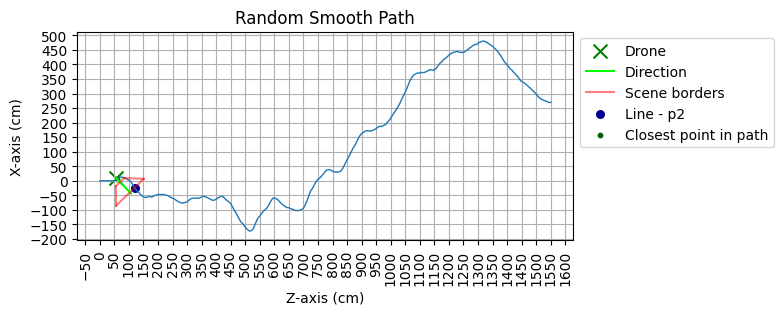

<Figure size 640x480 with 0 Axes>

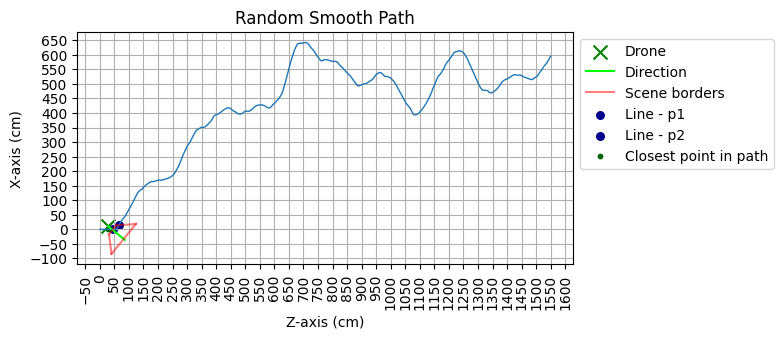

<Figure size 640x480 with 0 Axes>

In [ ]:
# start the processes
processes = [learner, *explorers]
for p in processes:
    p.start()

time.sleep(3) # wait for processes to be fully initialized

pbar = tqdm(position=0) # display the progress bar
out = widgets.Output(layout={'border': '1px solid black'})
display(out) # display the plot area

while True:
    # update the progress bar
    try:
        pbar_update = pbar_queue.get_nowait()
        pbar.update(1)
    except mp.queues.Empty:
        pass

    # update the plot
    try:
        render_dict = pickle.loads(render_queue.get_nowait())
        with out:
            Environment.render(dict(render_dict))
            clear_output(wait=True)
            plt.show(block=True)
            display(plt.gcf())
            plt.clf()
    except mp.queues.Empty:
        pass

In [ ]:
# interrupt the training
for p in processes:
    p.join()

# stop neptune
if log:
    run.stop()
# close the progress bar
pbar.close()

# Tests

## Reward func

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

slider_a = FloatSlider(value=1., min=0, max=1, step=0.1, description='speed:')
slider_b = FloatSlider(value=0, min=0, max=1, step=0.1, description='dist_p1_C:')
slider_c = FloatSlider(value=0, min=-1, max=1, step=0.1, description='drone_angle:')
slider_d = FloatSlider(value=0, min=-1, max=1, step=0.1, description='line_angle:')

def update_plot(speed_z, dist_p1_C, drone_angle, line_angle):
    plt.figure(figsize=(10, 6))
    plt.stackplot(
        dists,
        np.array([get_reward_(d, speed_z, dist_p1_C, drone_angle, line_angle) for d in dists]).T,
        labels=['travelled distance', 'speed', 'p1 centered', 'angle']
    )
    plt.xlabel('Distance')
    plt.ylabel('Reward')
    plt.ylim(0,10)
    plt.legend(loc=[1.05,0])
    plt.title('Stackplot of Rewards')
    plt.show()

In [35]:
def get_reward_(travelled_distance, speed_z, dist_p1_C, drone_angle,
                line_angle,
                alpha=1.5, beta=.5, gamma=1., delta=.75,):
    # travelled_distance in meters
    # speed_z in range [ 0., 1.]
    # dist_p1_C in range [0., 1.]
    # drone_angle and line_angle in range [-1., 1.]
    travelled_distance_percentage = travelled_distance / path_length

    reward_A = travelled_distance_percentage * alpha
    reward_B = travelled_distance_percentage * (speed_z * beta)
    reward_C = travelled_distance_percentage * ((1 - dist_p1_C) * gamma)
    reward_D = travelled_distance_percentage * ((1 - (abs(drone_angle - line_angle) / 2)) * delta)
    return reward_A, reward_B, reward_C, reward_D
    
path_length = 15.
dists = np.arange(0., path_length, .25)

interact(update_plot, speed_z=slider_a, dist_p1_C=slider_b, drone_angle=slider_c, line_angle=slider_d)

interactive(children=(FloatSlider(value=1.0, description='speed:', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.update_plot(speed_z, dist_p1_C, drone_angle, line_angle)>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

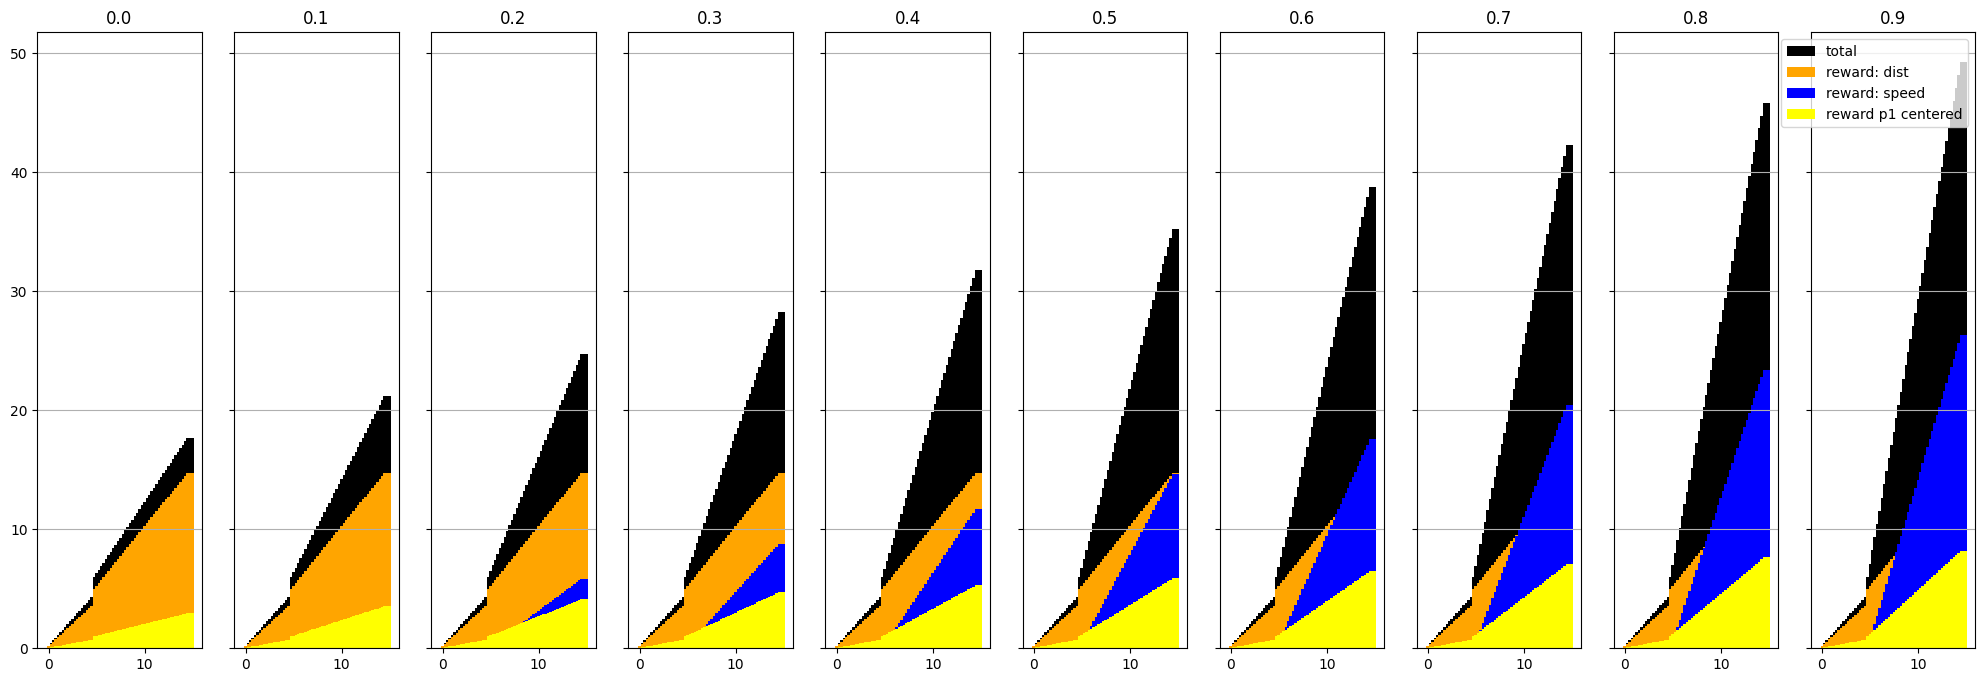

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def get_reward_(travelled_distance, dist_p1_C, 
                speed_z, speed_z_activation_dist=5, target_dist_p1_C=.15, 
                alpha=.75, beta=3, gamma=2):
    # speed_z in range [ 0., 1.]
    # dist_p1_C in range [-1., 1.]
    reward_A = travelled_distance * (alpha if travelled_distance < speed_z_activation_dist else 1.)
    reward_B = max(0, travelled_distance - speed_z_activation_dist) * beta * speed_z
    reward_C = (reward_A + reward_B) * np.interp(dist_p1_C, [ 0., 1.], [0.1, 1.]) * gamma
    return reward_A, reward_B, reward_C
    
fig, axes = plt.subplots(1,10, figsize=(25,8), sharey=True)
dists = np.arange(0.,15., .25)
for ax, speed in zip(axes, np.arange(0., 1.11, .1)):
    ax.set_title('%.1f' % speed)
    rewards = list(map(lambda d: get_reward_(d, 0, speed), dists))
    ax.bar(dists, list(map(sum, rewards)), color='black', label='total')
    ax.bar(dists, list(map(lambda r: r[0], rewards)), color='orange', label='reward: dist')
    ax.bar(dists, list(map(lambda r: r[1], rewards)), color='blue', label='reward: speed')
    ax.bar(dists, list(map(lambda r: r[2], rewards)), color='yellow', label='reward p1 centered')
    ax.grid(axis='y')
    plt.legend(loc='best')

## Drone & Line

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


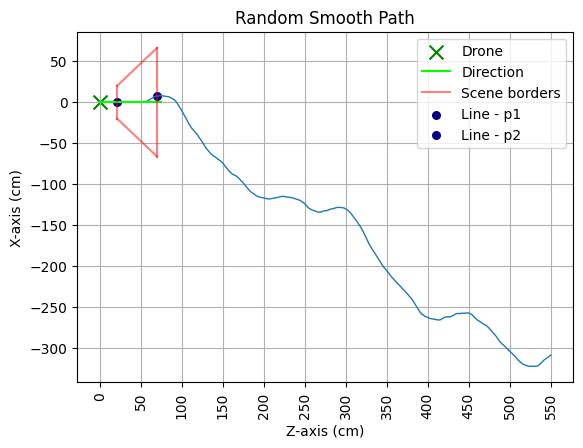

In [19]:
%load_ext autoreload
%autoreload 2
from Line import Line
from Drone import Drone
import matplotlib.pyplot as plt
seed = 23
fig = plt.figure()
line = Line(seed)
line.plot(show=False)
drone_params = {
    'seed': seed,
    'z_min_speed': z_min_speed,
    'z_max_speed': z_max_speed,
    'x_max_speed': x_max_speed,
    'max_angular_speed': max_angular_speed,
    'max_drift': max_drift,
    'allow_x_movement': allow_x_movement
}
drone = Drone(**drone_params)
drone.find_line(line)
drone.plot(show=False)
step = 50
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(step))
ax.yaxis.set_major_locator(plt.MultipleLocator(step))
ax.set_aspect('equal')
plt.legend()
plt.show()

## Environment

In [69]:
%load_ext autoreload
%autoreload 2
from Environment import Environment
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
testenv.drone.p1

[None, None]

In [71]:
environment_params = {
    'seed': seed,
    'max_allowed_dist': max_allowed_dist,
    'z_min_speed': z_min_speed,
    'z_max_speed': z_max_speed,
    'x_max_speed': x_max_speed,
    'max_angular_speed': max_angular_speed,
    'max_drift': max_drift,
    'allow_x_movement': allow_x_movement,
    'speed_z_activation_dist': speed_z_activation_dist,
    'target_dist_p1_C': target_dist_p1_C,
    'alpha': alpha,
    'beta':beta ,
    'gamma': gamma
}
testenv = Environment(**environment_params)
testout = widgets.Output(layout={'border': '1px solid black'})

In [77]:
action = {
    'speed_z': 0, # range [ 0,1] (0 = slow forward speed, 1 = fast forward speed)
    'speed_x': 0, # range [-1,1] (-1 = move left fast, 0 = no lateral movement, 1 = move right fast)
    'speed_a': -1, # range [-1,1] (-1 = turn left fast, 0 = no turn, 1 = turn right fast)
}

print('observation %s,\n reward %.3f, terminated %s, truncated %s' % testenv.step(list(action.values())))
testfig, testax = plt.subplots(figsize=(12, 8))
display(testout)
testenv.render(testout)

observation [-2, 1.0, 0.32272052081883285],
 reward 1.885, terminated True, truncated False


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

<Figure size 640x480 with 0 Axes>